Имеется датафрейм, представляющий собой данные об активности пользователей платформы онлайн-обучения. 

Колонки таблицы:

1. day - дата

2. user_id - идентификатор пользователя

3. days_offline – число дней начиная с последнего захода на сайт (0 – если в этот день были решения; 1 – если сегодня пользователь не заходил на сайт, но заходил вчера; 2 – если позавчера и т.д.)

3.	avg_submits_14d – среднее число попыток за последние 14 дней

4.	success_rate_14d –  доля успешных попыток за последние 14 дней

5.	solved_total  – суммарное число успешных сабмитов (к настоящему дню)

6.	target_14d – был ли пользователь онлайн следующие 14 дней? (1 – если не был, 0 – если был)

Необходимо построить модель, которая будет предсказывать активность пользователя в следущие 14 дней (target_14d).

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
df = pd.read_csv('churn_features_total.csv', parse_dates=['day'])
df.head()

,day,user_id,days_offline,avg_submits_14d,success_rate_14d,solved_total,target
0,2022-06-22,785,0,6.0,0.166667,1,1
1,2022-06-23,785,1,3.0,0.166667,1,1
2,2022-06-24,785,2,2.0,0.166667,1,1
3,2022-06-25,785,3,1.5,0.166667,1,1
4,2022-06-26,785,4,1.2,0.166667,1,1


In [2]:
df.dtypes

day                 datetime64[ns]
user_id                      int64
days_offline                 int64
avg_submits_14d            float64
success_rate_14d           float64
solved_total                 int64
target                       int64
dtype: object

In [3]:
df.isna().sum() # по всей видимости, пропуски возникли из-за деления на 0 при выгрузке данных

day                     0
user_id                 0
days_offline            0
avg_submits_14d         0
success_rate_14d    54554
solved_total            0
target                  0
dtype: int64

In [4]:
df = df.fillna(0)

In [5]:
df.sort_values(by='day', inplace=True) # отсортируем по датам для корректного сплитования
max_date = df['day'].max() # максимальная дата

In [7]:
#поскольку target - это значение за следущие 14 дней, 
#то в выгрузке не может быть значений за дату большую, чем за 14 дней до финальной даты выгрузки

delta = pd.Timedelta(14, "d")
df = df[df['day']<=max_date-delta] 

In [12]:
X = df.drop(['target', 'user_id', 'day'], axis=1)
y = df['target']

In [13]:
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=False)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

time_split = TimeSeriesSplit(n_splits=10)
model = XGBClassifier()
score = cross_val_score(model, X_train, y_train, cv=time_split, scoring = 'roc_auc', n_jobs = 5).mean()
print(score)

0.8990015997731012


In [15]:
from sklearn.model_selection import GridSearchCV

parameters = parameters = {
                    'max_depth': range (2, 10, 1),
                    'n_estimators': range(60, 220, 40),
                    'learning_rate': [0.1, 0.01, 0.05],
                    'gamma' : [0, 0.25, 0.5, 0.75,1],
                }

xgb_grid = GridSearchCV(model,
                        parameters,
                        scoring = 'roc_auc',
                        cv = time_split,
                        n_jobs = 5,
                        verbose=False)

xgb_grid.fit(X_train, y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

0.9012285766303876
{'gamma': 0.5, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 180}


In [16]:
churn_model = XGBClassifier(**xgb_grid.best_params_)
churn_model.fit(X_train, y_train)
y_pred = churn_model.predict(X_test)
print(roc_auc_score(y_test, y_pred))

0.8370588763303085


In [17]:
churn_model.save_model("churn_model.json")

#### Confidence Interval for ROC-AUC

Задача – реализовать оценку доверительного интервала для ROC-AUC с помощью бутстрепа.

In [18]:
from typing import Tuple

import numpy as np
from sklearn.base import ClassifierMixin
from sklearn.metrics import roc_auc_score


def roc_auc_ci(
    classifier: ClassifierMixin,
    X: np.ndarray,
    y: np.ndarray,
    conf: float = 0.95,
    n_bootstraps: int = 10_000,
) -> Tuple[float, float]:
    """Returns confidence bounds of the ROC-AUC
    
     Args:
        classifier : pretrained classification model
        X (np.ndarray): X_test dataset
        y (np.ndarray): y_test dataset
        conf (): confidence interval size
        n_bootstraps (int): numbers of subsamples
        
    Returns:
        Tuple: confidence interval boundaries       
        """
    alpha = 1-conf
    indicies = len(X)
    bootstrap_scores = []
    y_pred = classifier.predict(X)
    for _ in range(n_bootstraps):
        bootstrap_index = np.random.choice(indicies, indicies, replace=True)
        y_bootstrap = y[[bootstrap_index]]
        y_pred_bootstrap = y_pred[[bootstrap_index]]
        score = roc_auc_score(y_bootstrap, y_pred_bootstrap)
        bootstrap_scores.append(score)
        
    lcb, ucb = np.quantile(bootstrap_scores, [alpha / 2, 1 - alpha / 2])    
    return (lcb, ucb)

In [19]:
y_values = y_test.values
ci = roc_auc_ci(churn_model, X_test, y_values, 0.95, 1000)
print(ci)

(0.832307856549372, 0.8421314154367814)


#### Uncalibrated Probabilities

Необходимо реализовать 4 функции: 2 для кривых и 2 для отсечек. Для кривых также необходимо построить доверительный интервал. 

На входе:

•	y_true – лейблы 0 или 1 (размерности N)

•	y_prob – вероятности, предсказанные моделью (размерности N)

•	min_precision / min_specificity – Precision/Specificity по которым отсекаем порог

•	conf – размер дов.интервала

•	n_bootstrap – число бутстрэпнутых выборок

На выходе:

•	threshold_proba – значение вероятности, по которому берётся отсечка

•	max_recall – значение Recall при этой отсечке

•	recall, precision, specificity – Recall/Precision/Specificity при разных отсечках, все представляют собой массивы размера N+1 (мы можем поставить отсечку как между каждой парой соседних элементов, так и по краям)

•	precision_lcb / precision_ucb / specificity_lcb / specificity_ucb – границы дов.интервала бутстрепнутой Precision-Recall или Sensitivity-Specificity кривых (также размера N+1)

In [260]:
from typing import Tuple
from sklearn.metrics import precision_recall_curve, roc_curve
import numpy as np

y_prob = churn_model.predict_proba(X_test)[:,1]


def pr_threshold(
    y_true: np.ndarray,
    y_prob: np.ndarray,
    min_precision: float,
) -> Tuple[float, float]:
    """Returns threshold and recall (from Precision-Recall Curve)"""
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    idx_threshold = np.where(precision>=min_precision)[0][0]
    threshold_proba = thresholds[idx_threshold]
    max_recall = recall[idx_threshold]
    return threshold_proba, max_recall


def sr_threshold(
    y_true: np.ndarray,
    y_prob: np.ndarray,
    min_specificity: float,
) -> Tuple[float, float]:
    """Returns threshold and recall (from Specificity-Recall Curve)"""
    fpr, sensitivity, thresholds = roc_curve(y_test, y_prob)
    specificity = 1-fpr
    idx_threshold = np.where(specificity[::-1]>=min_specificity)[0][0]
    threshold_proba = thresholds[idx_threshold]
    max_sensitivity = sensitivity[idx_threshold]
    
    return threshold_proba, max_sensitivity


def pr_curve(
    y_true: np.ndarray,
    y_prob: np.ndarray,
    conf: float = 0.95,
    n_bootstrap: int = 10_000,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Returns Precision-Recall curve and it's (LCB, UCB)"""
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    
    alpha = 1-conf
    indicies = len(y_true)
    precision_scores = []
    scores = len(precision)

    precision_scores = []

    for _ in range(100):
        bootstrap_index = np.random.choice(indicies, indicies, replace=True)
        y_bootstrap = y_values[[bootstrap_index]]
        y_prob_bootstrap = y_prob[[bootstrap_index]]
        precision_boot, _, _ = precision_recall_curve(y_bootstrap, y_prob_bootstrap)
        precision_scores.append(precision_boot)

    boot_scores = [[score[i] for score in precision_scores] for i in range(scores)]
    ci = list(map(lambda x: np.quantile(x, [alpha / 2, 1 - alpha / 2]), boot_scores))
    precision_lcb = np.array([i[0] for i in ci])
    precision_ucb = np.array([i[1] for i in ci])

    return recall, precision, precision_lcb, precision_ucb

def sr_curve(
    y_true: np.ndarray,
    y_prob: np.ndarray,
    conf: float = 0.95,
    n_bootstrap: int = 10_000,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Returns Specificity-Recall curve and it's (LCB, UCB)"""
    
    fpr, sensitivity, thresholds = roc_curve(y_test, y_prob)
    specificity = 1-fpr

    alpha = 1-conf
    indicies = len(y_true)
    precision_scores = []
    scores = len(sensitivity)

    specificity_scores = []

    for _ in range(100):
        bootstrap_index = np.random.choice(indicies, indicies, replace=True)
        y_bootstrap = y_values[[bootstrap_index]]
        y_prob_bootstrap = y_prob[[bootstrap_index]]
        fpr_boot, _, _  = roc_curve(y_bootstrap, y_prob_bootstrap)
        specificity_boot = 1-fpr_boot
        specificity_scores.append(specificity_boot)

    boot_scores = [[score[i] for score in precision_scores] for i in range(scores)]
    ci = list(map(lambda x: np.quantile(x, [alpha / 2, 1 - alpha / 2]), boot_scores))
    specificity_lcb = np.array([i[0] for i in ci])
    specificity_ucb = np.array([i[1] for i in ci])    
        
    return sensitivity, specificity, specificity_lcb, specificity_ucb

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


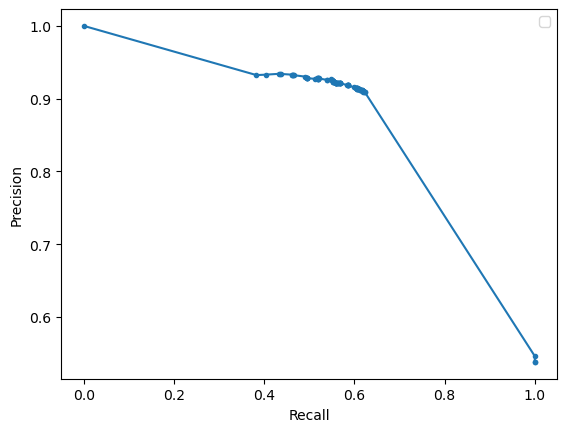

In [191]:
import matplotlib.pyplot as plt
# plot the precision-recall curves

plt.plot(recall, precision, marker='.')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


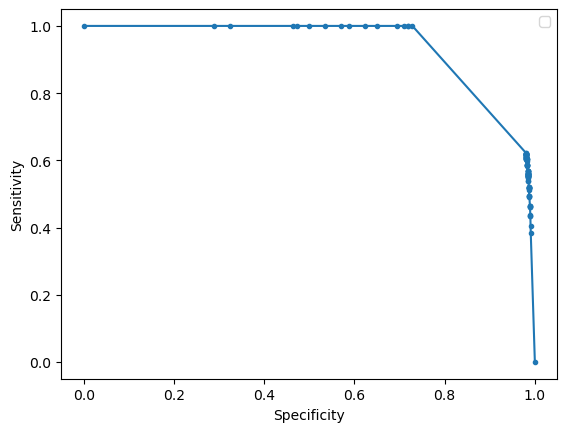

In [189]:
# plot the specificity-sensitivity curves

plt.plot(specificity, sensitivity, marker='.')
# axis labels
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
# show the legend
plt.legend()
# show the plot
plt.show()

In [20]:
df.head()

,day,user_id,days_offline,avg_submits_14d,success_rate_14d,solved_total,target
103897,2022-01-07,4438,19174,0.0,0.0,0,0
62523,2022-01-07,3045,19174,0.0,0.0,0,0
53161,2022-01-07,2714,19174,0.0,0.0,0,0
30662,2022-01-07,1890,19174,0.0,0.0,0,0
8767,2022-01-07,1082,19174,0.0,0.0,0,1
